# **Description**
In this notebook you will firstly train a CNN on cifar10 dataset. The CNN architecture you are going to use is ResNet18. You are going to train the model from scratch. Then you are going to implement targeted and untargeted FGSM attack and evaluate the performance of the trained model on the adversarial data.


**Attention!** Make sure you do not miss the questions asked at the end of the notebook.






Name: Ramtin Moslemi

Student ID: 99170553

#**Setups**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

In [ ]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
batch_size = 128
lr = 1e-3
epochs = 100

#**Data Preparation (10 pts)**
Use cifar10 dataset provided in torchvision and create train and test dataloaders according to the given transformations.

In [ ]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


###################################################
#prepare training and test datasets and loaders   #
###################################################



######################
# Your code goes here
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

######################

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:10<00:00, 16055170.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#**Building The Model**

In [ ]:
########################################
#define the model and optimizer        #
########################################

print('==> Building model..')
net = torchvision.models.resnet18(pretrained = False)

######################
# My code goes here
num_ftrs = net.fc.in_features
# Reset final fully connected layer
net.fc = nn.Linear(num_ftrs, 10)
######################

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer =  optim.SGD(net.parameters(), lr=lr, momentum=0.9)

==> Building model..


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#**Training and Evaluating The Model (20 pts)**

In [ ]:
#############################################
# define train and test functions           #
#############################################

def train(epoch, net, optimizer, trainloader):
    acc = None
    avg_loss = None
    ######################
    # Your code goes here
    criterion = nn.CrossEntropyLoss()
    net.train()
    total, correct, running_loss = 0, 0, 0
    for img, lbl in trainloader:
        # move data from cpu to gpu if needed
        img, lbl = img.to(device), lbl.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred = net(img)
        loss = criterion(pred, lbl)
        loss.backward()
        optimizer.step()
        # update running loss
        running_loss += loss.item() * pred.shape[0]
        # for measuring accuracy
        total += pred.shape[0]
        correct += sum(torch.argmax(pred, axis=1) == lbl).item()
    avg_loss = running_loss / total
    acc = correct / total
    ######################
    return avg_loss, acc


def test(epoch, net, testloader):
    acc = None
    ######################
    # Your code goes here
    net.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for img, lbl in testloader:
            # move data from cpu to gpu if needed
            img, lbl = img.to(device), lbl.to(device)
            # predict
            pred = net(img)
            # for measuring accuracy
            total += pred.shape[0]
            correct += sum(torch.argmax(pred, axis=1) == lbl).item()
    acc = correct / total
    ######################
    return acc

avg_losses, train_acc, test_acc = list(), list(), list()

In [ ]:
######################################################################
#train your model, make sure to save loss and accuracy in all epochs #
######################################################################

######################
# Your code goes here

for i_epoch in range(epochs):
    avg_loss, acc = train(i_epoch, net, optimizer, trainloader)
    avg_losses.append(avg_loss)
    train_acc.append(100 * acc)
    acc = test(i_epoch, net, testloader)
    test_acc.append(100 * acc)
    print(f'Epoch {str(i_epoch).zfill(3)}: train_acc = {train_acc[-1]:.2f}%, test_acc = {test_acc[-1]:.2f}%, loss = {avg_losses[-1]:.4f}')


#######################

Epoch 000: train_acc = 32.25%, test_acc = 44.19%, loss = 1.8365
Epoch 001: train_acc = 43.83%, test_acc = 49.21%, loss = 1.5233
Epoch 003: train_acc = 51.47%, test_acc = 55.77%, loss = 1.3250
Epoch 004: train_acc = 54.45%, test_acc = 57.20%, loss = 1.2500
Epoch 005: train_acc = 56.88%, test_acc = 58.83%, loss = 1.1937
Epoch 006: train_acc = 58.71%, test_acc = 61.16%, loss = 1.1446
Epoch 007: train_acc = 60.79%, test_acc = 62.32%, loss = 1.0944
Epoch 008: train_acc = 62.15%, test_acc = 62.44%, loss = 1.0580
Epoch 009: train_acc = 63.36%, test_acc = 64.64%, loss = 1.0227
Epoch 010: train_acc = 64.57%, test_acc = 65.80%, loss = 0.9947
Epoch 011: train_acc = 65.62%, test_acc = 65.91%, loss = 0.9635
Epoch 012: train_acc = 66.48%, test_acc = 67.53%, loss = 0.9397
Epoch 013: train_acc = 67.45%, test_acc = 68.46%, loss = 0.9139
Epoch 014: train_acc = 67.99%, test_acc = 69.21%, loss = 0.8913
Epoch 015: train_acc = 68.98%, test_acc = 69.19%, loss = 0.8719
Epoch 016: train_acc = 69.58%, test_acc 

In [ ]:
########################################
#save your model and history           #
########################################


######################
# Your code goes here
PATH = 'ResNet18_CIFAR-10_100'
torch.save(net.state_dict(), PATH + '.pth')
with open('list.txt', 'w') as file:
    for item in zip(avg_losses, train_acc, test_acc):
        file.write(str(item) + '\n')
# load
# net.load_state_dict(torch.load(PATH + '.pth'))
# model.eval()

#######################

In [ ]:
# net.load_state_dict(torch.load('/content/drive/MyDrive/ResNet18_CIFAR-10_100.pth'))
test(1, net, testloader)

0.7812

##**Train and Test Loss and Accuracy Plots**

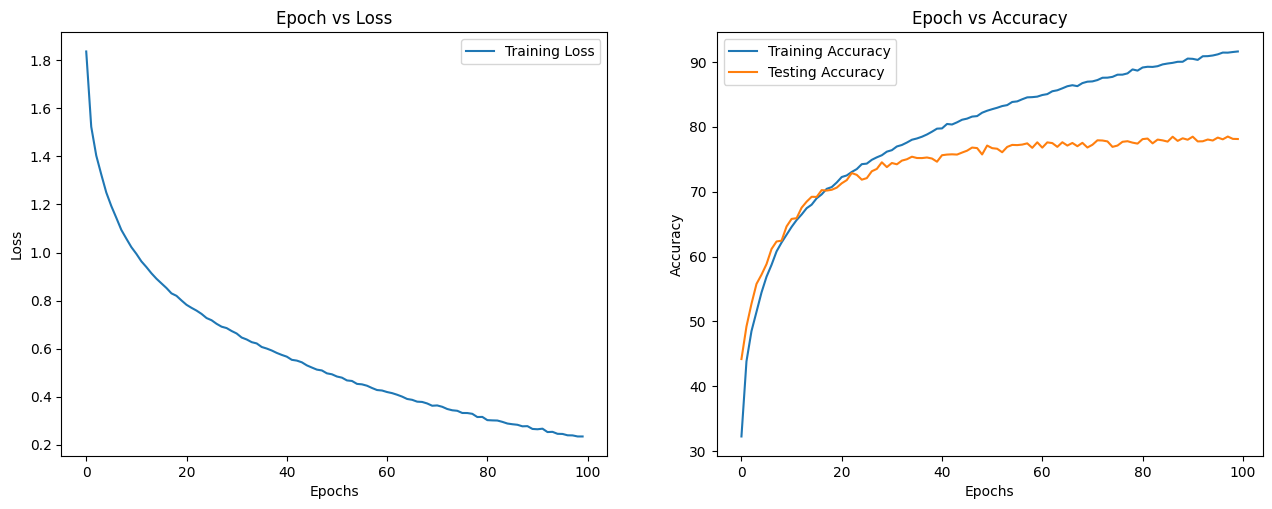

In [ ]:
#############################################################
#plot train and test loss and accuracy dusring the training #
#############################################################

######################
# Your code goes here

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(list(range(epochs)), avg_losses, label='Training Loss')
# ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Epoch vs Loss')
ax1.legend()

ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
ax2.plot(list(range(epochs)), test_acc, label='Testing Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Epoch vs Accuracy')
ax2.legend()

fig.set_size_inches(15.5, 5.5)
plt.show()
######################

# **Visualizing filters (12pts)**

In this section, you're going to visualize filters of some of the layers.

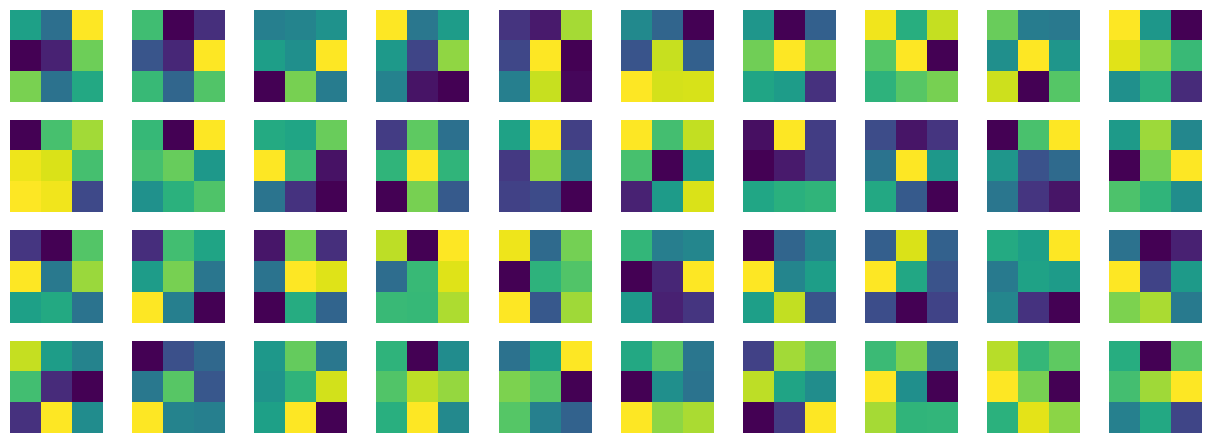

In [ ]:
#########################################################
#Visualize the filters of the specified layers          #
#########################################################


conv_layers = [net.layer1[0].conv1, net.layer1[0].conv2, net.layer2[0].conv1, net.layer2[0].conv2]

##############################
# Your code goes here
sample_count = 10
fig, axes = plt.subplots(len(conv_layers), sample_count)
fig.set_size_inches(15.5, 5.5)
for idx, conv_layer in enumerate(conv_layers):
    in_ch, out_ch, k1, k2 = conv_layer.weight.shape
    samples = torch.randint(min(in_ch, out_ch), (sample_count, 2))
    for sample in range(sample_count):
        i, j = samples[sample]
        s = conv_layer.weight[i, j].cpu().detach().numpy()
        axes[idx, sample].imshow(s)
        axes[idx, sample].axis('off')
plt.show()
##############################



#**Attention Heatmap (8pts)**


Some methods have been proposed to measure how much a model attends to each individual pixel in an image. One of the most well-known methods for this, is [GradCAM](https://github.com/jacobgil/pytorch-grad-cam/), which utilizes the gradient of the model on the last convolutional layers to compute attention scores. Here we want to visualize a number of samples and the model's attention heatmap on them.

In [ ]:
!pip install grad-cam

In [ ]:
from pytorch_grad_cam import XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

Select 2 random images from each class in the test set and put them in an array called samples.       

In [ ]:
samples = None
######################
# Your code goes here
# test
samples = list()
batch_x, batch_y = next(iter(testloader))
for class_id in range(10):
    mask = (batch_y == class_id).nonzero().squeeze()
    samples.append(np.random.choice(mask, 2))

 Now we define the heatmap generator. Here we use XGradCAM, which is an extention of the original GradCAM.

In [ ]:
heat_map_generator = XGradCAM(
    model=net,
    target_layers=[net.layer4[-1]],
)

Visualize the selected images, and the attention heatmap of the model on each of them.

In [ ]:
class InvertNormalize(transforms.Normalize):
    def __init__(self, mean, std):
        if not torch.is_tensor(mean):
            mean = torch.tensor(mean)
        if not torch.is_tensor(std):
            std = torch.tensor(std)
        mean = -mean / std
        std = 1.0 / std
        super(InvertNormalize, self).__init__(mean, std)

transform_inverse = transforms.Compose([
    InvertNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    transforms.Lambda(lambda x: x.clamp(0, 1)),  # Clamp to stay within valid range
    transforms.ToPILImage()  # Convert tensor to PIL image
])

transform_inverse_no_pil = transforms.Compose([
    InvertNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    transforms.Lambda(lambda x: x.clamp(0, 1)),  # Clamp to stay within valid range
])

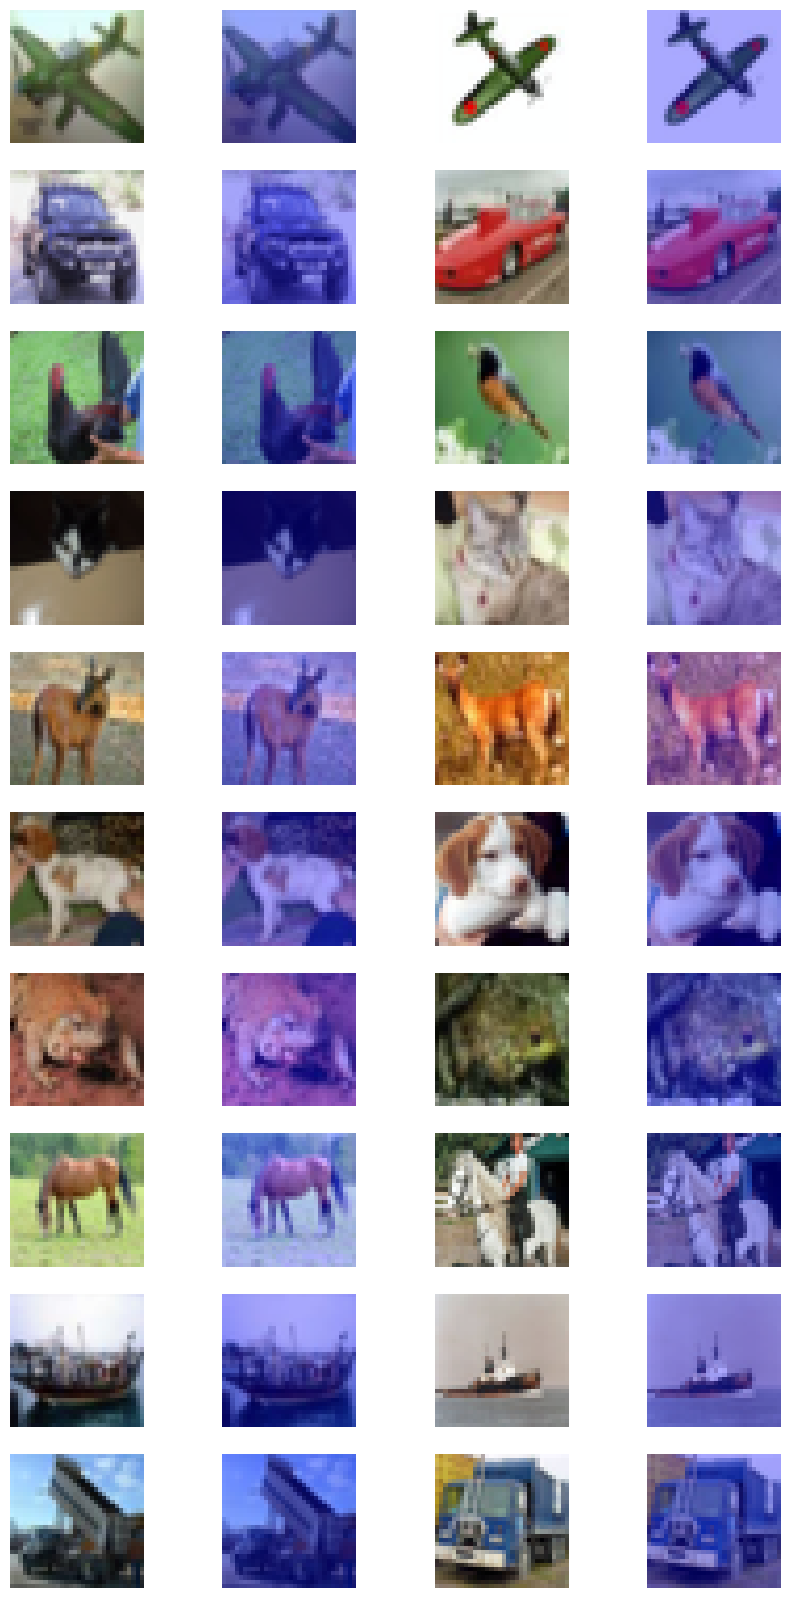

In [ ]:
#############################################################################################
#visualize two test sample from each class and their corresponding attention heatmap        #
#############################################################################################

def visualize_heatmap(image, unnormalized_image, heat_map_generator):
    '''
    inputs:
        image: image which is normalized according to the statistics of the dataset. type: torch.Tensor. shape: [1, channels, width, height]
        unnormalized_image: image that you are going to visualize. the value of its pixels must be in [0,1]. type: numpy array. shape: [width, height, channels]
        heat_map_generator: XGradCAM instance

    returns: visualization of the heatmap on the image
    '''
    grayscale_cam = heat_map_generator(input_tensor=image)
    grayscale_cam = grayscale_cam[0, :]

    vis = show_cam_on_image(unnormalized_image, grayscale_cam, use_rgb=True)
    return vis


######################
# Your code goes here
fig, axes = plt.subplots(10, 4)
fig.set_size_inches(10.5, 20.5)
for idx, sample in enumerate(samples):
    first_image, second_image = batch_x[sample[0]], batch_x[sample[1]]
    first_pil, second_pil = transform_inverse(first_image), transform_inverse(second_image)
    first_unnorm = transform_inverse_no_pil(first_image).permute(1, 2, 0).numpy()
    second_unnorm = transform_inverse_no_pil(second_image).permute(1, 2, 0).numpy()
    axes[idx, 0].imshow(first_pil)
    axes[idx, 0].axis('off')
    axes[idx, 1].imshow(visualize_heatmap(first_image.unsqueeze(0), first_unnorm, heat_map_generator))
    axes[idx, 1].axis('off')
    axes[idx, 2].imshow(second_pil)
    axes[idx, 2].axis('off')
    axes[idx, 3].imshow(visualize_heatmap(second_image.unsqueeze(0), second_unnorm, heat_map_generator))
    axes[idx, 3].axis('off')
plt.show()


#**FGSM Attack (50 pts)**
In this section you must implement targeted and untargeted FGSM attack and evalute the trained model performance on the adversarial data.

##**Untargeted FGSM Attack (30 pts)**

In [ ]:
########################################
#define untargeted FGSM attack         #
########################################


def FGSM (model, x, y, epsilon):
    """
    inputs:
        model: model to be attacked
        x: input image
        y: label
        epsilon: clipping threshold for FGSM

    outputs:
        x': the perturbed image
        delta: the added perturbation
        y': prediction of the model for the perturbed input
    """
    delta = None

    ######################
    # Your code goes here
    model.eval()
    x, y = x.to(device), y.to(device)
    x.requires_grad = True
    pred = model(x)
    criterion = nn.CrossEntropyLoss()
    model.zero_grad()
    loss = criterion(pred, y)
    loss.backward()
    data_grad = x.grad.data
    sign_data_grad = data_grad.sign()
    delta = epsilon * sign_data_grad
    return x+delta, delta, model(x+delta)

###**Evaluation**


 For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [ ]:
  ######################
  # Your code goes here
batch_x, batch_y = next(iter(testloader))
x, y = batch_x[10], batch_y[10]
eps = [1/255, 4/255, 8/255, 16/255]
for e in eps:
    # get adversarial attack, perturbation and new pred
    x_adv, delta, y_pred = FGSM(net, batch_x, batch_y, e)
    # measure performance
    attacked = torch.argmax(y_pred, axis=1)
    real = batch_y
    pred = torch.argmax(net(batch_x.to(device)), axis=1)
    success = sum(attacked.cpu() == real.cpu()).item()
    total = sum(pred.cpu() == real.cpu()).item()
    print(f'for epsilon={e}:\t{100*success/total:.2f}% are still correclty classified')

for epsilon=0.00392156862745098:	97.12% are still correclty classified
for epsilon=0.01568627450980392:	77.88% are still correclty classified
for epsilon=0.03137254901960784:	50.96% are still correclty classified
for epsilon=0.06274509803921569:	25.00% are still correclty classified


In [ ]:
eps = [1/255, 4/255, 8/255]
for e in eps:
    success, total = 0, 0
    for x, y in testloader:
        # get adversarial attack, perturbation and new pred
        x_adv, delta, y_pred = FGSM(net, x, y, e)
        # measure performance
        attacked = torch.argmax(y_pred, axis=1)
        real = y
        pred = torch.argmax(net(x.to(device)), axis=1)
        success += sum(attacked.cpu() == real.cpu()).item()
        total += sum(pred.cpu() == real.cpu()).item()
    print(f'for epsilon={e}:\t{100*success/total:.2f}% are still correclty classified')

for epsilon=0.00392156862745098:	94.19% are still correclty classified
for epsilon=0.01568627450980392:	75.01% are still correclty classified
for epsilon=0.03137254901960784:	52.80% are still correclty classified


###**FGSM by gradually increasing $ϵ$**

FGSM attack may not work for small $\epsilon$, on the other hand we want to alter image as insignificant as possible, so here is what we do, we start from $\epsilon = \frac{1}{255}$ and if the attack was unsuccessful, we increase $\epsilon$ by $\frac{1}{255}$. The procedure goes on until the predicted label is different from the ground truth.

In [ ]:
#######################################################
#increase epsilon gradually till the label is changed. The function can be implemented recursively.#
#######################################################

def generate_adversarial_FGSM (model, x, label, initial_epsilon=1/255):
    """
    inputs:
        model: model to be attacked
        x: input image
        y: label
        epsilon: intial clipping threshold for FGSM

    outputs:
        epsilon: the epsilon that flips the label.
        delta: the added perturbation
        y': prediction of the model for the perturbed input
      """



  ######################
  # Your code goes here
    x_adv, delta, y_pred = FGSM(model, x, label, initial_epsilon)
    if torch.argmax(y_pred, axis=1).cpu() != label.cpu():
        return x_adv, delta, y_pred
    else:
        return generate_adversarial_FGSM (model, x, label, initial_epsilon + 1/255)

### **Visualization**
Pick 10 samples from cifar10 test set, each from one class, make sure the selected samples are classified correctly. Plot these samples. Take note that the selected data must not be transformed by train or test transformations while visualisation.

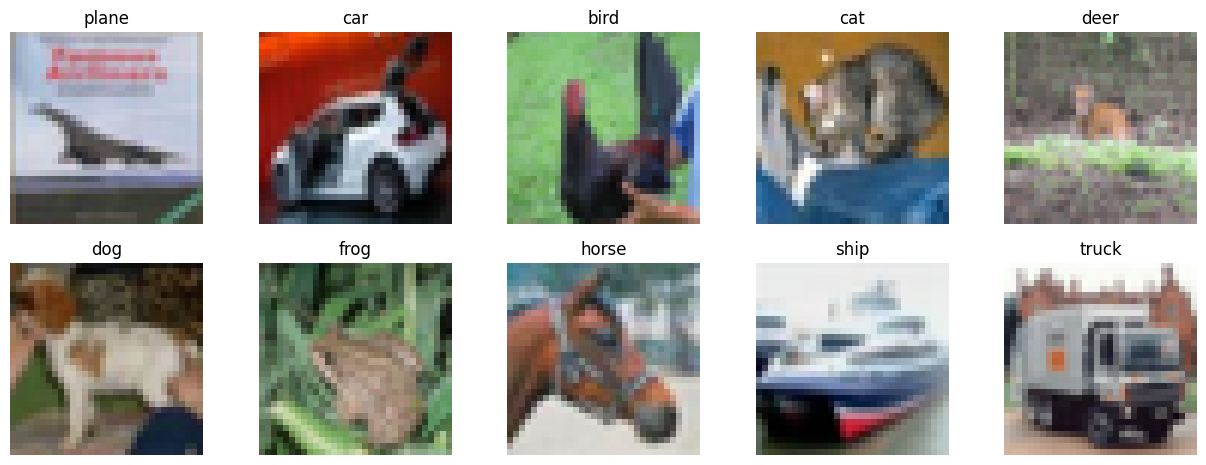

In [ ]:
#############################################################################################
#visualize one test sample from each class and make sure that they are correctly labeled.   #
#save index of these samples, since they are needed in the following sections.              #
#############################################################################################






#######################
# Your code goes here
fig, axes = plt.subplots(2, 5)

selected_values = list()

batch_x, batch_y = next(iter(testloader))
pred_y = net(batch_x.to(device))
pred_y = torch.argmax(pred_y, axis=1)
correctly_predicted = (pred_y.cpu() == batch_y)

for class_id in range(10):
    mask = (batch_y == class_id) & correctly_predicted
    if mask.any():
        mask = mask.nonzero()
        selected_value = mask[0].item()
        selected_values.append(selected_value)

for class_id, idx in zip(range(10), selected_values):
    axes[class_id // 5, class_id % 5].imshow(transform_inverse(batch_x[idx]))
    axes[class_id // 5, class_id % 5].axis('off')
    axes[class_id // 5, class_id % 5].set_title(classes[class_id])

fig.set_size_inches(15.5, 5.5)
# print(selected_values)

Now, apply untargetted FGSM attack ``` generate_adversarial_FGSM ``` on the selected samples. Visualize the original image, the perturbed image, and the perturbation. since the perturbation is imperceptible, magnify it by the value of $\frac{1}{\epsilon}$ before visualization.

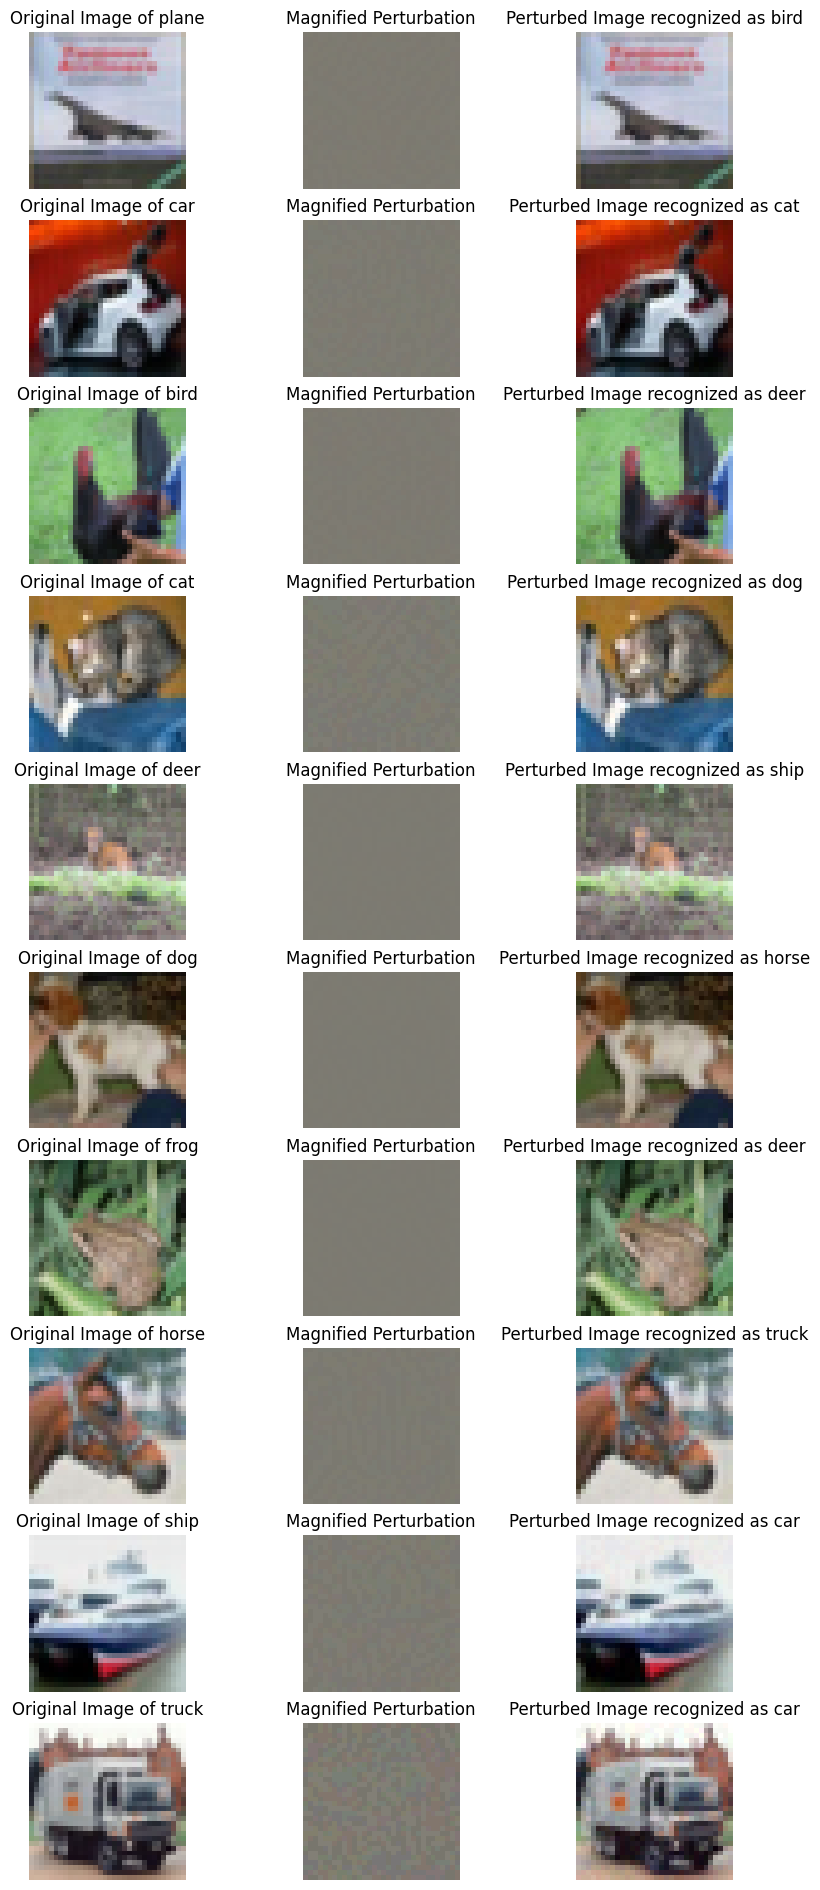

In [ ]:
######################################################################################################
#visualize the selected samples, their corresponding perturbed image, and the magnified perturbation #
#also print the ground truth and the predicted label for each sample                                 #
######################################################################################################




######################
# Your code goes here
fig, axes = plt.subplots(10, 3)

for class_id, idx in zip(range(10), selected_values):
    x, y = batch_x[idx].unsqueeze(0), batch_y[idx].unsqueeze(0)
    x_adv, delta, y_pred = generate_adversarial_FGSM(net, x, y)
    pred_class = classes[torch.argmax(y_pred, axis=1)]

    axes[class_id, 0].imshow(transform_inverse(x.squeeze()))
    axes[class_id, 0].axis('off')
    axes[class_id, 0].set_title(f'Original Image of {classes[class_id]}')

    axes[class_id, 1].imshow(transform_inverse(delta.squeeze()))
    axes[class_id, 1].axis('off')
    axes[class_id, 1].set_title('Magnified Perturbation')

    axes[class_id, 2].imshow(transform_inverse(x_adv.squeeze()))
    axes[class_id, 2].axis('off')
    axes[class_id, 2].set_title(f'Perturbed Image recognized as {pred_class}')

fig.set_size_inches(10, 24)

##**Targeted FGSM Attack (20pts)**
implement targeted FGSM attack.

In [ ]:
########################################
#define tergeted FGSM attack           #
########################################

def FGSM_targeted (model, x, y, y_targ, epsilon):
    """
      inputs:
        model: model to be attacked
        x: input image
        y: label
        y_targ = target label
        epsilon: clipping threshold for FGSM

      outputs:
        x': the perturbed image
        delta: the added perturbation
    """

    delta = None

    ######################
    # Your code goes here
    model.eval()
    x, y = x.to(device), y.to(device)
    x.requires_grad = True
    pred = model(x)
    criterion = nn.CrossEntropyLoss()
    model.zero_grad()
    loss = criterion(pred, y_targ)
    loss.backward()
    data_grad = x.grad.data
    sign_data_grad = data_grad.sign()
    delta = -epsilon * sign_data_grad

    return x+delta, delta

###**Evaluation**
for each sample, select the most probable lable as the target label (if the most probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [ ]:
######################
# Your code goes here
most_prob_acc = list()
most_prob_new = list()
eps = [1/255, 4/255, 8/255, 16/255, 32/255]
for e in eps:
    success, total = 0, 0
    target_change, all_count = 0, 0
    for x, y in testloader:
        real = y
        net_pred = net(x.to(device))
        pred = torch.argmax(net_pred, axis=1)
        net_pred[torch.arange(len(real)), real.type(torch.int)] = 0
        targ = torch.argmax(net_pred, axis=1)
        # get adversarial attack, perturbation
        x_adv, delta = FGSM_targeted(net, x, y, targ, e)
        # measure performance
        y_pred = net(x_adv.to(device))
        attacked = torch.argmax(y_pred, axis=1)
        target_change += sum(attacked.cpu() == targ.cpu()).item()
        success += sum(attacked.cpu() == real.cpu()).item()
        total += sum(pred.cpu() == real.cpu()).item()
        all_count += len(real)
    print(f'for epsilon={e:.3f}:\t{100*success/total:.2f}% are still correclty classified, {100*target_change/all_count:.2f}% have new target, ')
    most_prob_acc.append(100 * success / all_count)
    most_prob_new.append(100*target_change/all_count)

for epsilon=0.004:	94.10% are still correclty classified, 26.37% have new target, 
for epsilon=0.016:	74.38% are still correclty classified, 41.78% have new target, 
for epsilon=0.031:	52.25% are still correclty classified, 58.92% have new target, 
for epsilon=0.063:	26.21% are still correclty classified, 78.41% have new target, 
for epsilon=0.125:	8.32% are still correclty classified, 88.83% have new target, 


for each sample, select the least probable lable as the target label (if the least probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [ ]:
######################
# Your code goes here
least_prob_acc = list()
least_prob_new = list()
eps = [1/255, 4/255, 8/255, 16/255, 32/255]
for e in eps:
    success, total = 0, 0
    target_change, all_count = 0, 0
    for x, y in testloader:
        real = y
        net_pred = net(x.to(device))
        pred = torch.argmax(net_pred, axis=1)
        net_pred[torch.arange(len(real)), real.type(torch.int)] = 1
        targ = torch.argmin(net_pred, axis=1)
        total += sum(pred.cpu() == real.cpu()).item()
        # get adversarial attack, perturbation
        x_adv, delta = FGSM_targeted(net, x, y, targ, e)
        # measure performance
        y_pred = net(x_adv.to(device))
        attacked = torch.argmax(y_pred, axis=1)
        success += sum(attacked.cpu() == real.cpu()).item()
        target_change += sum(attacked.cpu() == targ.cpu()).item()
        all_count += len(real)
    print(f'for epsilon={e:.3f}:\t{100*success/total:.2f}% are still correclty classified, {100*target_change/total:.2f}% have new target, ')
    least_prob_acc.append(100 * success / all_count)
    least_prob_new.append(100*target_change/all_count)

for epsilon=0.004:	99.82% are still correclty classified, 0.00% have new target, 
for epsilon=0.016:	96.61% are still correclty classified, 0.00% have new target, 
for epsilon=0.031:	86.60% are still correclty classified, 0.09% have new target, 
for epsilon=0.063:	65.78% are still correclty classified, 1.23% have new target, 
for epsilon=0.125:	36.49% are still correclty classified, 7.04% have new target, 


plot accuracy of model with respect to $\epsilon$ both for least probable and most probable target labels (both in a single plot).

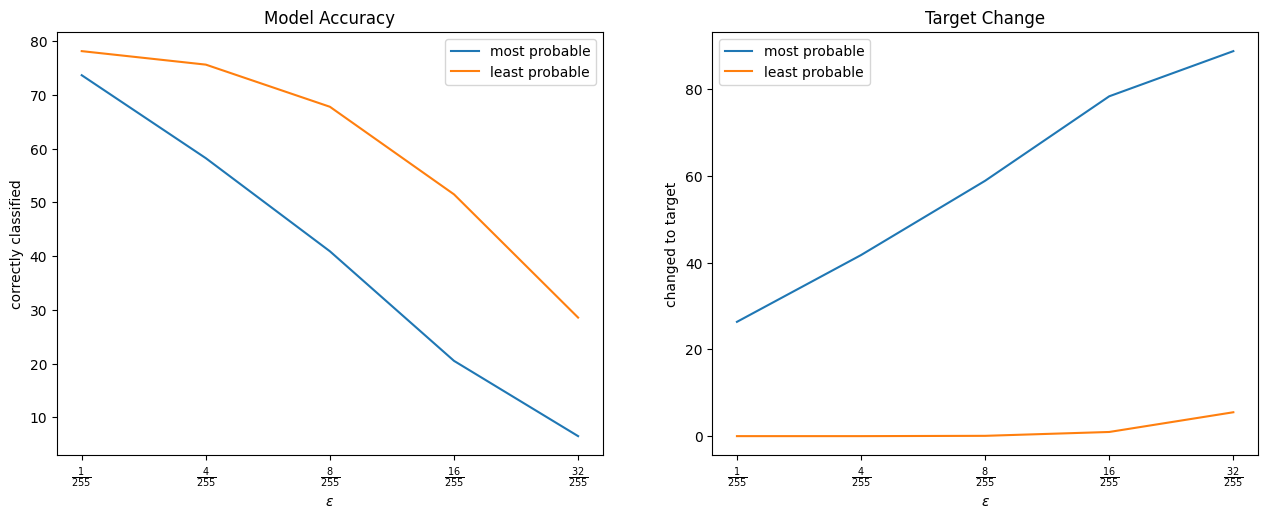

In [ ]:
######################
# Your code goes here
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(most_prob_acc, label='most probable')
ax1.plot(least_prob_acc, label='least probable')
new_ticks = [r'$\frac{1}{255}$',r'$\frac{4}{255}$', r'$\frac{8}{255}$', r'$\frac{16}{255}$', r'$\frac{32}{255}$']
ax1.set_title('Model Accuracy')
ax1.legend()
ax1.set_xticks(range(len(eps)), new_ticks)
ax1.set_ylabel('correctly classified')
ax1.set_xlabel(r'$\epsilon$')

ax2.plot(most_prob_new, label='most probable')
ax2.plot(least_prob_new, label='least probable')
ax2.set_title('Target Change')
ax2.legend()
ax2.set_xticks(range(len(eps)), new_ticks)
ax2.set_ylabel('changed to target')
ax2.set_xlabel(r'$\epsilon$')

fig.set_size_inches(15.5, 5.5)
plt.show()

#**Questions (10 pts)**

1. What was the effect of $\epsilon$ in targeted and untargeted FGSM attack according to your observations?

2. Compare performance of the model on the least probable and most probable targetted FGSM attacks, justify your observation.

1. Greater values of epsilon correspond to greater perturbation and increase the chance of misclassification. Larger epsilon values make it easier to achieve successful targeted attacks, especially if the target class is distant from the original class.

2. Most probable targetted attacks yield more success (more labels are changed to the targets) while least probable attacks are not very successfull (new labels are rarely the desired targets). If the target has higher probability, we can expect better attacks since the model is already likely to select the target. So the higher the initial probability of the target means we need less change (perturbation in case of attacks) to be able to change the prediction to the new target. In contrast the least probable targets are more difficult to be chosen in one iteration as we need greater change (perturbation) to be able to change the predicted class.